## Day 30 Lecture 1 Assignment

In this assignment, we will build our first random forest model. We will use a dataset containing churn information for a telephone company's customers.

In [32]:
!pip install category_encoders

     |████████████████████████████████| 81kB 2.2MB/s 


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import classification_report

Read in the telecom churn dataset.

https://raw.githubusercontent.com/Thinkful-Ed/data-science-lectures/master/telecom_churn.csv

In [2]:
# answer here
telecom = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-science-lectures/master/telecom_churn.csv')

Perform the following preprocessing steps:

- This dataset has many columns; identify a subset of 10-15 features that you think could affect a customer's propensity to churn (also called "customer loss" or "customer attrition"). Include at least 1 categorical variable.
- Drop all rows that containing any missing values (this should be a fairly small number of rows)
- Convert the response from a string to a binary 1-0 encoding.

In [3]:
telecom.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


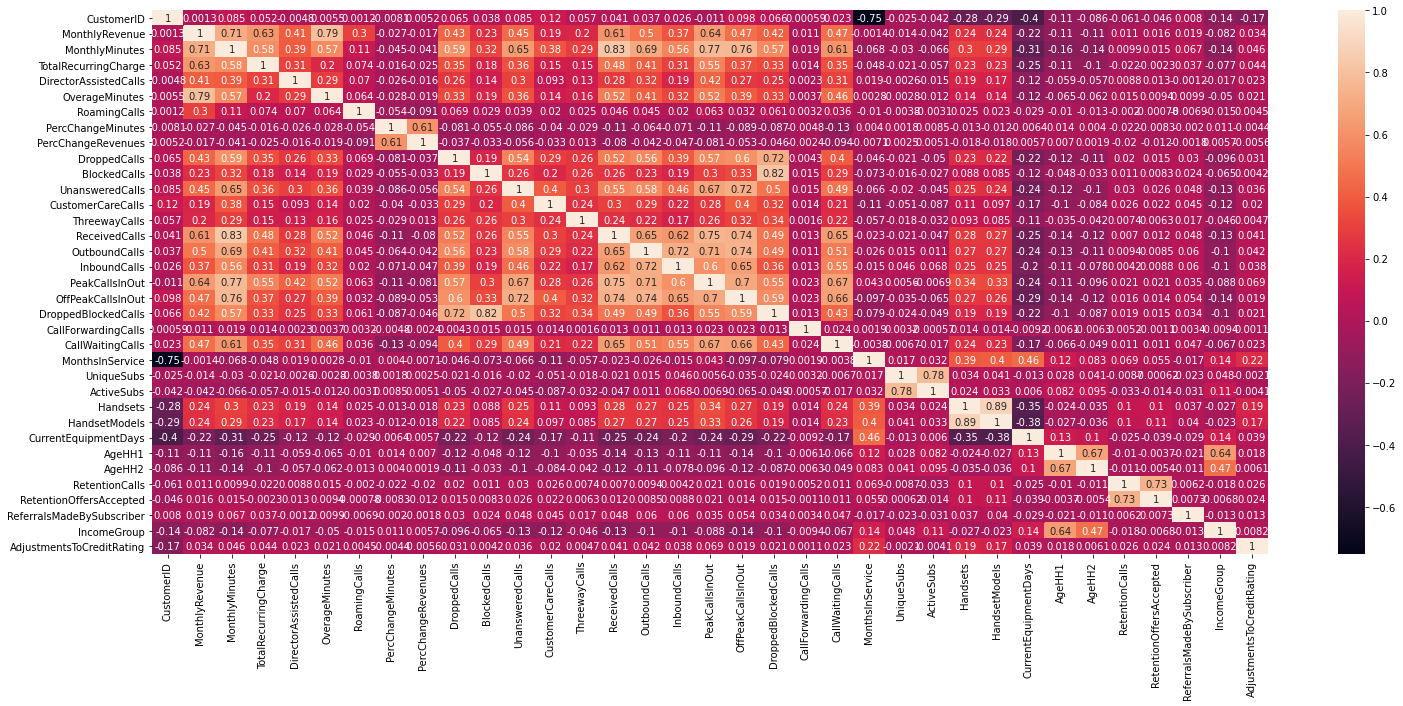

In [4]:
plt.figure(figsize=(25,10))
sns.heatmap(telecom.corr(), annot=True)
plt.show()

In [5]:
#df = pd.concat([df, pd.get_dummies(df[column], drop_first=True)], axis=1)
churn = pd.get_dummies(telecom['Churn'], drop_first=True)
telecom = pd.concat([telecom, churn], axis=1)
telecom.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,Yes
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No,1
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes,1
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes,0
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No,0
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes,1


In [6]:
# answer goes here
#features: MonthlyRevenue, TotalRecurringCharge, MonthsInService, ChildrenInHH, OwnsComputer, AgeHH1, MaritalStatus
#CreditRating, DirectorAssistedCalls, CurrentEquipmentDays, MonthlyMinutes
#target variable: Churn (dummy column=Yes)
telecom2 = telecom[['Yes', 'MonthlyRevenue', 'TotalRecurringCharge', 'MonthsInService', 'CurrentEquipmentDays', 'MonthlyMinutes',
                    'OwnsComputer', 'CreditRating', 'DirectorAssistedCalls', 'OffPeakCallsInOut', 'RetentionCalls', 'PercChangeMinutes']]
telecom2.head()

,Yes,MonthlyRevenue,TotalRecurringCharge,MonthsInService,CurrentEquipmentDays,MonthlyMinutes,OwnsComputer,CreditRating,DirectorAssistedCalls,OffPeakCallsInOut,RetentionCalls,PercChangeMinutes
0,1,24.00,22.0,61,361.0,219.0,Yes,1-Highest,0.25,24.0,1,-157.0
1,1,16.99,17.0,58,1504.0,10.0,Yes,4-Medium,0.00,1.0,0,-4.0
2,0,38.00,38.0,60,1812.0,8.0,No,3-Good,0.00,3.7,0,-2.0
3,0,82.28,75.0,59,458.0,1312.0,No,4-Medium,1.24,303.7,0,157.0
4,1,17.14,17.0,53,852.0,0.0,Yes,1-Highest,0.00,0.0,0,0.0


In [8]:
telecom2 = telecom2.dropna()
telecom2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50679 entries, 0 to 51043
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Yes                    50679 non-null  uint8  
 1   MonthlyRevenue         50679 non-null  float64
 2   TotalRecurringCharge   50679 non-null  float64
 3   MonthsInService        50679 non-null  int64  
 4   CurrentEquipmentDays   50679 non-null  float64
 5   MonthlyMinutes         50679 non-null  float64
 6   OwnsComputer           50679 non-null  object 
 7   CreditRating           50679 non-null  object 
 8   DirectorAssistedCalls  50679 non-null  float64
 9   OffPeakCallsInOut      50679 non-null  float64
 10  RetentionCalls         50679 non-null  int64  
 11  PercChangeMinutes      50679 non-null  float64
dtypes: float64(7), int64(2), object(2), uint8(1)
memory usage: 4.7+ MB


Although some implementations of tree-based models support categorical variables directly, scikit-learn's implementation does not, so we will need to convert our categorical variable(s) into numbers. In linear regression, we used one-hot/dummy encoding, but this has drawbacks that can be particularly problematic in the context of trees. Namely, dummy encoding can lead to very sparse columns when dealing with high-dimensional categorical features; the tree treats these levels as indepedent features is very unlikely to make a split on any of the individual levels, since the corresponding columns consist almost entirely consist of a single value.

Ideally, we would consider all of the levels simultaneously, which trees can do efficiently. However, sklearn does not implement this efficient algorithm for splitting on categorical variables. In this situation, a better alternative to dummy encoding is leave-one-out-encoding. This transforms each categorical into its conditional probability of the positive class, excluding the observation itself to avoid potential data leakage. Perform the following steps:

- Create an 80-20 train/test split on the data
- Fit a leave-one-out encoder to the training data and encode the categorical variables in the training data. The category_encoders package is helpful for this task. (Note that this ordering is important; if we fitted the encoder to the full dataset before making the train/test split, we would introduce data leakage by allowing the test data to affecting the estimates of the category-conditional probabilities.)

In [9]:
# answer goes here
X = telecom2.drop(['Yes'], axis=1)
y = telecom2['Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
#category_encoder
#category_encoders.leave_one_out.LeaveOneOutEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
encoder = LeaveOneOutEncoder(cols=['OwnsComputer', 'CreditRating'])
encoder.fit(X_train, y_train)
X_train_LOO = encoder.transform(X_train)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [12]:
X_train_LOO

,MonthlyRevenue,TotalRecurringCharge,MonthsInService,CurrentEquipmentDays,MonthlyMinutes,OwnsComputer,CreditRating,DirectorAssistedCalls,OffPeakCallsInOut,RetentionCalls,PercChangeMinutes
48702,52.66,73.0,8,241.0,560.0,0.28481,0.217155,0.00,122.3,0,146.0
21556,57.63,53.0,15,55.0,689.0,0.28481,0.298556,0.25,116.3,0,-181.0
12060,36.58,17.0,25,737.0,68.0,0.28481,0.302449,0.00,10.7,0,26.0
25774,41.31,40.0,13,384.0,232.0,0.28481,0.298556,0.25,19.7,0,-55.0
4252,31.97,30.0,32,978.0,76.0,0.28481,0.298556,1.98,7.0,0,-24.0
...,...,...,...,...,...,...,...,...,...,...,...
2914,76.13,75.0,38,127.0,336.0,0.28481,0.302449,0.74,8.7,0,84.0
29059,67.19,72.0,17,501.0,960.0,0.28481,0.217155,0.74,137.0,0,-75.0
30259,14.09,10.0,11,320.0,156.0,0.28481,0.298556,0.00,17.0,0,-10.0
6214,97.39,86.0,29,413.0,1594.0,0.28481,0.307589,0.25,79.0,0,253.0


Next, fit the random forest model. You can tinker with or tune the parameters if you like, although we will use the default parameter values.

In [14]:
# answer goes here
forest = RandomForestClassifier()
forest.fit(X_train_LOO, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
forest.base_estimator_

To evaluate our model, produce the predicted values for the test sample. Remember to apply our previously fitted encoder to the test data prior to making predictions.

In [16]:
# answer goes here
X_test_LOO = encoder.transform(X_test)
y_pred_test = forest.predict(X_test_LOO)

After making the predictions, print out the classification report (sklearn.metrics.classification_report). In addition, plot the confusion matrix and ROC curve. How did our model perform?

In [17]:
# answer goes here
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_test)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.95      0.82      7181
           1       0.54      0.15      0.24      2955

    accuracy                           0.71     10136
   macro avg       0.63      0.55      0.53     10136
weighted avg       0.67      0.71      0.65     10136



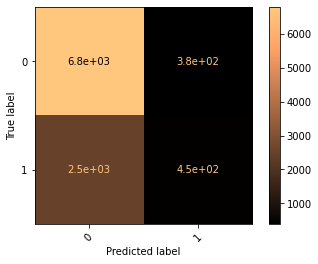

In [20]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(forest, X_test_LOO, y_test, cmap='copper', xticks_rotation=45)
plt.show()

Area under the ROC curve: 0.549


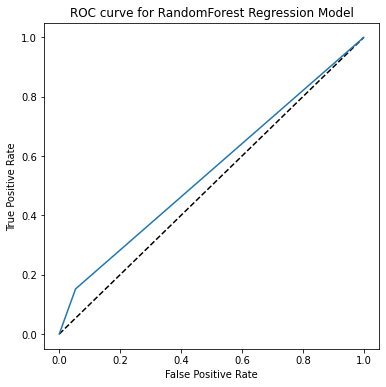

In [22]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_pred_test)
print('Area under the ROC curve: {:.3f}'.format(auc))

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RandomForest Regression Model')
plt.show()

Print the feature importances, ordered by importance from high to low. What is the default sklearn feature importance metric?

In [25]:
# answer goes here
forest_importance = pd.Series(forest.feature_importances_, X_train_LOO.columns).sort_values(ascending=False)
forest_importance

CurrentEquipmentDays     0.149620
MonthlyMinutes           0.144617
PercChangeMinutes        0.143560
MonthlyRevenue           0.140269
OffPeakCallsInOut        0.124603
MonthsInService          0.092021
TotalRecurringCharge     0.078224
DirectorAssistedCalls    0.058965
CreditRating             0.045786
OwnsComputer             0.015763
RetentionCalls           0.006573
dtype: float64

Impurity is the default metric for sklearn feature importance.